In [1]:
%matplotlib inline
from qutip import *
from qutip import fidelity
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors
import scipy.special as sp
import scipy.integrate as integrate
import scipy.optimize as opt
from scipy.optimize import curve_fit
from functools import reduce
from IPython.display import display, Markdown, Latex

In [2]:
kmax = 5
alpha = 300e6 * 2 * np.pi
detuning = alpha / 2
wq = 5e9 * 2 * np.pi
wd = wq + detuning
phi_d = np.pi / 4
Gate_duration = 20e-9
t_0 = Gate_duration
sigma = Gate_duration / 4
Q = np.sin(phi_d)
I = np.cos(phi_d)
lambda_param = 0.5
beta = (-lambda_param**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)

# Pulses
Ref : https://arxiv.org/pdf/0901.0534

Gaussian pulse is $I_x(t) = I_\pi(t) = A \exp\left(-\frac{(t - t_0 / 2)^2}{2 \sigma^2}\right) - B$

where the value of A and B must satisfy the following two conditions:
First of all, at time t=0:  $I_x(t) = 0$ , also we must have: $\int_0^{t_0} I_\pi(t) \, dt = \pi$; So 
$
A = \frac{-\pi}{\frac{t_0}{\exp\left(\frac{t_0^2}{8\sigma^2}\right)} - \sqrt{2\pi} \sigma \, \text{erf}\left(\frac{t_0}{2\sqrt{2}\sigma}\right)}
$
and
$
B = \frac{\pi}{-t_0 + \exp\left(\frac{t_0^2}{8\sigma^2}\right) \sqrt{2\pi} \sigma \, \text{erf}\left(\frac{t_0}{2\sqrt{2}\sigma}\right)}
$
and
$\text{erf}\left(\frac{t_0}{2\sqrt{2}\sigma}\right) = \frac{2}{\sqrt{\pi}} \int_0^\left(\frac{t_0}{2\sqrt{2}\sigma}\right) e^{-t^2} \, dt$

And DRAG pulse is:

Ref : https://arxiv.org/pdf/1005.1279

$$Q(t) = -i\beta\frac{dI_x(t)}{dt} $$ 
which
$$\frac{dI_x(t)}{dt} = -A \cdot \frac{(t - t_0 / 2)}{\sigma^2} \exp\left(-\frac{(t - t_0 / 2)^2}{2 \sigma^2}\right)$$

where :

$A$ is the amplitude of the pulse \
$B$ is a constant that adjusts the baseline of the Gaussian pulse \
$t_0$ is the center time of the pulse \
$\sigma$ is the standard deviation of the Gaussian envelope \
$\lambda$ is the DRAG parameter which is from 0 to 1 \
$\beta= \frac{\lambda^2}{4\alpha}$ which is the amplitude of the DRAG pulse

In [3]:
def calculate_A(args):
    return -np.pi / ( (args['t_0'] / np.exp(args['t_0']**2 / (8 * args['sigma']**2))) - 
               np.sqrt(2 * np.pi) * args['sigma'] * sp.erf(args['t_0'] / (2 * np.sqrt(2) * args['sigma'])))

def calculate_B(args):
    return np.pi / ( -args['t_0'] + np.exp(args['t_0']**2 / (8 * args['sigma']**2)) * 
               np.sqrt(2 * np.pi) * args['sigma'] * sp.erf(args['t_0'] / (2 * np.sqrt(2) * args['sigma'])))

def gaussian(t, args):
    return args["A"] * np.exp(-((t - args["t_0"] / 2)**2) / (2 * args["sigma"]**2)) - args["B"]

def gaussian_drive(t, args):
    return args["I"] * np.sin(args["wd"] * t) * gaussian(t, args)

def derivative_of_Gaussian(t, args):
    return -args["A"] * (t - args['t_0'] / 2) / (args['sigma']**2) * np.exp(-((t - args['t_0'] / 2) ** 2) / (2 * args['sigma']**2))

def DRAG(t, args):
    return -1j * (args['lambda']**2 / (4 * args['alpha'])) * derivative_of_Gaussian(t, args)

def DRAG_drive(t, args):
    return args["Q"] * np.cos((args["wd"] * t)) * DRAG(t, args)

args = {'t_0':t_0,'sigma':sigma,'wd':wd,'wq':wq,'I':I,'Q':Q,'lambda':lambda_param,'alpha':alpha}
args["A"] = calculate_A(args) / args["I"]
args["B"] = calculate_B(args) / args["I"]

In [4]:
A_value = calculate_A(args)
B_value = calculate_B(args)

print(f"A = {A_value/2/np.pi/1e6} MHz")
print(f"B = {B_value/2/np.pi/1e6} MHz")

A = 54.01799649540967 MHz
B = 7.3105408555806175 MHz


C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


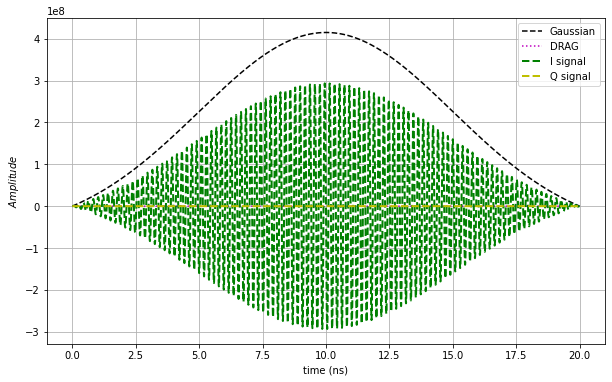

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(tList * 1e9, gaussian(tList, args), "k--")
plt.plot(tList * 1e9, DRAG(tList, args), "m:")
plt.plot(tList * 1e9, gaussian_drive(tList, args), "g", linewidth=2, linestyle='dashed')
plt.plot(tList * 1e9, DRAG_drive(tList, args), "y", linewidth=2, linestyle='dashed')
plt.legend([r"Gaussian" , r"DRAG", r"I signal", r"Q signal", "derivative of Gaussian"], loc="best")
plt.rc('grid', linestyle=":", color='black')
plt.xlabel(r'time (ns)')
plt.ylabel(r'$ Amplitude $')
plt.grid(True)

# Hamiltonian before Rotating Frame Approximation (RFA)
REF :
1. https://arxiv.org/pdf/1904.06560
### Definition of the Transmon Qubit Hamiltonian in Python

The given Hamiltonian represents a transmon qubit with additional terms for control fields, such as the DRAG term (which mitigates leakage errors) and a signal drive term.
$$H_0 = w_q \cdot b^\dagger b + \frac{\alpha}{2} \cdot (b^\dagger b)^2$$
- $H_0$ represents the qubit's base Hamiltonian, which includes the transmon qubit's energy levels and a nonlinear term corresponding to the anharmonicity of the qubit. $w_q$ is the qubit frequency, $b^\dagger b$ represents the number operator. The term $\frac{I}{2}$ shifts the energy of all states by a constant factor, commonly used to set the zero-point energy or to account for the offset in the system.

$$H_{d}(\sigma_x) = \text{amp} \cdot (b + b^\dagger)$$

$$H_{d}(\sigma_y) = \text{dragamp} \cdot \left(1j \cdot (b - b^\dagger)\right)$$
- $H_d(\sigma_x)$ and $H_d(\sigma_y)$ represent the control fields used to manipulate the qubit. $H_{d}(\sigma_x)$ represents the control Hamiltonian for a $\sigma_x$  operation (also called a bit-flip operation), and $H_{d}(\sigma_y)$ represents the control Hamiltonian for a $\sigma_y$ operation (a phase-flip operation)

In [6]:
b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = (b + b.dag())
Hd_sigmay = (1j * (b - b.dag()))

In [7]:
H = [H0, [Hd_sigmax, gaussian_drive], [Hd_sigmay, DRAG_drive]]
c_ops = []
opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
result = mesolve(H, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)

10.0%. Run time:   0.14s. Est. time left: 00:00:00:01


C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\Hannaneh\AppData\Roaming\Python\Python39\site-packages\qutip\solver\solver_base.py:459: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.54s. Est. time left: 00:00:00:01
40.0%. Run time:   0.73s. Est. time left: 00:00:00:01
50.0%. Run time:   0.93s. Est. time left: 00:00:00:00
60.0%. Run time:   1.14s. Est. time left: 00:00:00:00
70.0%. Run time:   1.36s. Est. time left: 00:00:00:00
80.0%. Run time:   1.54s. Est. time left: 00:00:00:00
90.0%. Run time:   1.70s. Est. time left: 00:00:00:00
100.0%. Run time:   1.87s. Est. time left: 00:00:00:00
Total run time:   1.87s


In [8]:
result.states[-1]

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.53405725e-03-2.78590902e-09j  1.21743017e-03-6.71716449e-02j
  -3.44376008e-05+2.25712931e-04j  3.46588335e-08-1.59364722e-07j
  -2.23581181e-11+4.76192388e-11j]
 [ 1.21745194e-03+6.71705683e-02j  9.95452864e-01+1.16864649e-09j
  -3.35310328e-03-4.49589832e-04j  2.37174751e-06+4.70895870e-07j
  -6.36368825e-10-1.28783191e-10j]
 [-3.91414708e-05-2.56754645e-04j -3.81430103e-03+5.10947365e-04j
   1.30786955e-05+1.61726238e-09j -9.32976774e-09-5.89526017e-10j
   2.60067266e-12-6.01146457e-14j]
 [ 5.17104024e-08+2.37025926e-07j  3.52690498e-06-7.02541670e-07j
  -1.21977673e-08+7.76122950e-10j  9.05756413e-12+1.42020680e-16j
  -8.95854874e-16+2.73015992e-15j]
 [-3.53453265e-11-9.96448535e-11j -1.40747749e-09+3.10786242e-10j
   4.96706389e-12-1.71727704e-13j -1.91815694e-15-2.16006922e-15j
   1.47373873e-15-7.21249176e-19j]]

In [9]:
def calculate_probability_from_dm(res):
    dms = res.states
    probabilities = []
    for dm in dms:
        probabilities.append(dm.diag())
    return np.array(probabilities)

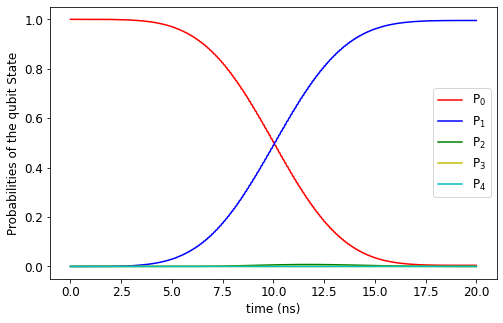

In [10]:
probabilities = calculate_probability_from_dm(result)
plt.figure(figsize=(8, 5))
plt.plot(tList*1e9, probabilities[:,0], 'r')
plt.plot(tList*1e9, probabilities[:,1], 'b')
plt.plot(tList*1e9, probabilities[:,2], 'g')
plt.plot(tList*1e9, probabilities[:,3], 'y')
plt.plot(tList*1e9, probabilities[:,4], 'c')


plt.xlabel("time (ns)", fontsize=12)
plt.ylabel("Probabilities of the qubit State", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('grid', linestyle=":", color='black')
plt.legend([r"$\mathrm{P_0}$", r"$\mathrm{P_1}$", r"$\mathrm{P_2}$", r"$\mathrm{P_3}$",r"$\mathrm{P_4}$"], loc='best' , fontsize=12)

In [11]:
target = np.array([[0, 0, 0, 0 , 0],
                  [0, 1, 0, 0 , 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0 , 0],
                  [0, 0, 0, 0 , 0]])
state_matrix = result.states[-1].full()
fidelityoflastpoint = np.abs(np.trace(np.dot(state_matrix, target)))
print("Fidelity Percentage:", fidelityoflastpoint * 100, "%")

Fidelity Percentage: 99.5452864050253 %


# $\lambda$ tuning

In [12]:
lambda_values = np.linspace(0,10, 100)
beta = (-lambda_param**2) / 4 / alpha
tList = np.arange(0, Gate_duration, 1e-12)
b = destroy(kmax)
H0 = wq * (b.dag() * b) + alpha / 2 * (b.dag() * b)**2
Hd_sigmax = (b + b.dag())
Hd_sigmay = (1j * (b - b.dag()))

def simulate_for_lambda(lambda_param, tList, args):
    args['lambda'] = lambda_param
    H = [H0, [Hd_sigmax, gaussian_drive], [Hd_sigmay, DRAG_drive]]
    c_ops = []
    opts = Options(atol=1e-12, rtol=1e-10, store_states=True, nsteps=1e7)
    result = mesolve(H, ket2dm(fock(kmax, 0)), tList, c_ops, [], args=args, options=opts, progress_bar=True)
    probabilities = calculate_probability_from_dm(result)
    return probabilities[-1, 1]

final_probabilities = []
for lambda_val in lambda_values:
    prob = simulate_for_lambda(lambda_val, tList, args)
    final_probabilities.append(prob)

best_lambda = lambda_values[np.argmax(final_probabilities)]
best_probability = np.max(final_probabilities)

10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.34s. Est. time left: 00:00:00:01
30.0%. Run time:   0.57s. Est. time left: 00:00:00:01
40.0%. Run time:   0.81s. Est. time left: 00:00:00:01
50.0%. Run time:   1.08s. Est. time left: 00:00:00:01
60.0%. Run time:   1.39s. Est. time left: 00:00:00:00
70.0%. Run time:   1.57s. Est. time left: 00:00:00:00
80.0%. Run time:   1.78s. Est. time left: 00:00:00:00
90.0%. Run time:   1.95s. Est. time left: 00:00:00:00
100.0%. Run time:   2.13s. Est. time left: 00:00:00:00
Total run time:   2.13s
10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.75s. Est. time left: 00:00:00:02
30.0%. Run time:   1.22s. Est. time left: 00:00:00:02
40.0%. Run time:   1.77s. Est. time left: 00:00:00:02
50.0%. Run time:   2.30s. Est. time left: 00:00:00:02
60.0%. Run time:   2.82s. Est. time left: 00:00:00:01
70.0%. Run time:   3.32s. Est. time left: 00:00:00:01
80.0%. Run time:   3.79s. Est. time left: 00:00:00:00
90.

70.0%. Run time:   4.28s. Est. time left: 00:00:00:01
80.0%. Run time:   4.86s. Est. time left: 00:00:00:01
90.0%. Run time:   5.28s. Est. time left: 00:00:00:00
100.0%. Run time:   5.69s. Est. time left: 00:00:00:00
Total run time:   5.69s
10.0%. Run time:   0.37s. Est. time left: 00:00:00:03
20.0%. Run time:   0.89s. Est. time left: 00:00:00:03
30.0%. Run time:   1.47s. Est. time left: 00:00:00:03
40.0%. Run time:   2.09s. Est. time left: 00:00:00:03
50.0%. Run time:   2.75s. Est. time left: 00:00:00:02
60.0%. Run time:   3.42s. Est. time left: 00:00:00:02
70.0%. Run time:   4.03s. Est. time left: 00:00:00:01
80.0%. Run time:   4.62s. Est. time left: 00:00:00:01
90.0%. Run time:   5.07s. Est. time left: 00:00:00:00
100.0%. Run time:   5.65s. Est. time left: 00:00:00:00
Total run time:   5.65s
10.0%. Run time:   0.40s. Est. time left: 00:00:00:03
20.0%. Run time:   0.90s. Est. time left: 00:00:00:03
30.0%. Run time:   1.54s. Est. time left: 00:00:00:03
40.0%. Run time:   2.20s. Est. t

20.0%. Run time:   1.00s. Est. time left: 00:00:00:03
30.0%. Run time:   1.61s. Est. time left: 00:00:00:03
40.0%. Run time:   2.25s. Est. time left: 00:00:00:03
50.0%. Run time:   3.00s. Est. time left: 00:00:00:03
60.0%. Run time:   3.72s. Est. time left: 00:00:00:02
70.0%. Run time:   4.32s. Est. time left: 00:00:00:01
80.0%. Run time:   4.88s. Est. time left: 00:00:00:01
90.0%. Run time:   5.33s. Est. time left: 00:00:00:00
100.0%. Run time:   5.76s. Est. time left: 00:00:00:00
Total run time:   5.76s
10.0%. Run time:   0.45s. Est. time left: 00:00:00:04
20.0%. Run time:   1.00s. Est. time left: 00:00:00:03
30.0%. Run time:   1.61s. Est. time left: 00:00:00:03
40.0%. Run time:   2.26s. Est. time left: 00:00:00:03
50.0%. Run time:   3.07s. Est. time left: 00:00:00:03
60.0%. Run time:   3.92s. Est. time left: 00:00:00:02
70.0%. Run time:   4.53s. Est. time left: 00:00:00:01
80.0%. Run time:   5.05s. Est. time left: 00:00:00:01
90.0%. Run time:   5.57s. Est. time left: 00:00:00:00
100

80.0%. Run time:   5.13s. Est. time left: 00:00:00:01
90.0%. Run time:   5.60s. Est. time left: 00:00:00:00
100.0%. Run time:   6.10s. Est. time left: 00:00:00:00
Total run time:   6.10s
10.0%. Run time:   0.55s. Est. time left: 00:00:00:04
20.0%. Run time:   1.14s. Est. time left: 00:00:00:04
30.0%. Run time:   1.82s. Est. time left: 00:00:00:04
40.0%. Run time:   2.49s. Est. time left: 00:00:00:03
50.0%. Run time:   3.22s. Est. time left: 00:00:00:03
60.0%. Run time:   3.87s. Est. time left: 00:00:00:02
70.0%. Run time:   4.57s. Est. time left: 00:00:00:01
80.0%. Run time:   5.25s. Est. time left: 00:00:00:01
90.0%. Run time:   5.73s. Est. time left: 00:00:00:00
100.0%. Run time:   6.22s. Est. time left: 00:00:00:00
Total run time:   6.22s
10.0%. Run time:   0.51s. Est. time left: 00:00:00:04
20.0%. Run time:   1.08s. Est. time left: 00:00:00:04
30.0%. Run time:   1.85s. Est. time left: 00:00:00:04
40.0%. Run time:   2.51s. Est. time left: 00:00:00:03
50.0%. Run time:   3.18s. Est. t

30.0%. Run time:   1.78s. Est. time left: 00:00:00:04
40.0%. Run time:   2.48s. Est. time left: 00:00:00:03
50.0%. Run time:   3.25s. Est. time left: 00:00:00:03
60.0%. Run time:   4.01s. Est. time left: 00:00:00:02
70.0%. Run time:   4.78s. Est. time left: 00:00:00:02
80.0%. Run time:   5.35s. Est. time left: 00:00:00:01
90.0%. Run time:   5.85s. Est. time left: 00:00:00:00
100.0%. Run time:   6.30s. Est. time left: 00:00:00:00
Total run time:   6.30s
10.0%. Run time:   0.64s. Est. time left: 00:00:00:05
20.0%. Run time:   1.28s. Est. time left: 00:00:00:05
30.0%. Run time:   1.90s. Est. time left: 00:00:00:04
40.0%. Run time:   2.61s. Est. time left: 00:00:00:03
50.0%. Run time:   3.36s. Est. time left: 00:00:00:03
60.0%. Run time:   4.11s. Est. time left: 00:00:00:02
70.0%. Run time:   4.86s. Est. time left: 00:00:00:02
80.0%. Run time:   5.43s. Est. time left: 00:00:00:01
90.0%. Run time:   5.91s. Est. time left: 00:00:00:00
100.0%. Run time:   6.35s. Est. time left: 00:00:00:00
To

90.0%. Run time:   6.26s. Est. time left: 00:00:00:00
100.0%. Run time:   6.80s. Est. time left: 00:00:00:00
Total run time:   6.81s
10.0%. Run time:   0.57s. Est. time left: 00:00:00:05
20.0%. Run time:   1.21s. Est. time left: 00:00:00:04
30.0%. Run time:   1.97s. Est. time left: 00:00:00:04
40.0%. Run time:   2.64s. Est. time left: 00:00:00:03
50.0%. Run time:   3.35s. Est. time left: 00:00:00:03
60.0%. Run time:   4.08s. Est. time left: 00:00:00:02
70.0%. Run time:   4.80s. Est. time left: 00:00:00:02
80.0%. Run time:   5.49s. Est. time left: 00:00:00:01
90.0%. Run time:   6.03s. Est. time left: 00:00:00:00
100.0%. Run time:   6.50s. Est. time left: 00:00:00:00
Total run time:   6.50s
10.0%. Run time:   0.53s. Est. time left: 00:00:00:04
20.0%. Run time:   1.16s. Est. time left: 00:00:00:04
30.0%. Run time:   1.93s. Est. time left: 00:00:00:04
40.0%. Run time:   2.67s. Est. time left: 00:00:00:04
50.0%. Run time:   3.53s. Est. time left: 00:00:00:03
60.0%. Run time:   4.23s. Est. t

40.0%. Run time:   2.83s. Est. time left: 00:00:00:04
50.0%. Run time:   3.64s. Est. time left: 00:00:00:03
60.0%. Run time:   4.41s. Est. time left: 00:00:00:02
70.0%. Run time:   5.12s. Est. time left: 00:00:00:02
80.0%. Run time:   5.87s. Est. time left: 00:00:00:01
90.0%. Run time:   6.54s. Est. time left: 00:00:00:00
100.0%. Run time:   7.04s. Est. time left: 00:00:00:00
Total run time:   7.05s
10.0%. Run time:   0.59s. Est. time left: 00:00:00:05
20.0%. Run time:   1.35s. Est. time left: 00:00:00:05
30.0%. Run time:   2.11s. Est. time left: 00:00:00:04
40.0%. Run time:   3.06s. Est. time left: 00:00:00:04
50.0%. Run time:   3.83s. Est. time left: 00:00:00:03
60.0%. Run time:   4.61s. Est. time left: 00:00:00:03
70.0%. Run time:   5.39s. Est. time left: 00:00:00:02
80.0%. Run time:   6.12s. Est. time left: 00:00:00:01
90.0%. Run time:   6.86s. Est. time left: 00:00:00:00
100.0%. Run time:   7.46s. Est. time left: 00:00:00:00
Total run time:   7.46s
10.0%. Run time:   0.58s. Est. t

Best lambda: 6.363636363636363
Maximum probability at the final time: (1.0013384451554688-4.2583875404676234e-05j)


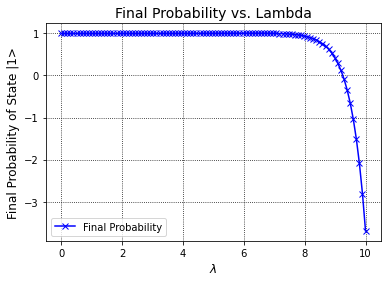

In [13]:
print(f"Best lambda: {best_lambda}")
print(f"Maximum probability at the final time: {best_probability}")
plt.plot(lambda_values, final_probabilities, label="Final Probability", marker='x', linestyle='-', color='b')
plt.xlabel(r"$\lambda$", fontsize=12)
plt.ylabel("Final Probability of State |1>", fontsize=12)
plt.title("Final Probability vs. Lambda", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()